In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 411 ms (started: 2023-01-31 21:46:35 -08:00)


# How Does Dimensionality Reduction Transform Distances?

In terms of distances in the ambient and embedded space, how do methods that are successful at uncovering clusters in high-dimensional data (e.g. UMAP, t-SNE) differ from methods like PCA?

Some more specific questions:

* As the intrinsic dimensionality of a dataset increases, how does the distribution of nearest neighbor distances change?
* As the intrinsic dimensionality of a dataset increases, how does the distribution of *random* neighbor distances change?
* How does applying PCA affect the distribution of those distances?
* How does applying UMAP or t-SNE affect the distribution of those distances?
* What sort of transformation is applied to a given near or random distance when applying those DR techniques?

To answer those questions here are some functions to:

* Calculate the distances between nearest neighbors in a dataset.
* Calculate the distances for randomly chosen items in a dataset.
* Plot a histogram of those distances.
* Carry out dimensionality reduction on the dataset. The default transformation is PCA.
* Recalculate the nearest neighbor and random distances (using the same items).
* Plot a histogram of the embedded distances.
* Plot a scatterplot showing how these distances are transformed by the dimensionality reduction.
* Report some summary statistics on those distance distributions.

The results below are for embedded into 2D. I do *not* show the actual results of the embedding.

In [2]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns

import drnb.embed.pipeline as pl
from drnb.neighbors import calculate_neighbors
from drnb.neighbors.distances import neighbor_distances
from drnb.neighbors.hubness import describe
from drnb.neighbors.nbrinfo import NearestNeighbors
from drnb.neighbors.random import random_neighbors


def embed_nbrs(data, method, params, ambient_nbrs):
    embedded = pl.embed(data, method=method, params=params)
    ennd = neighbor_distances(
        embedded, ambient_nbrs.near.idx, distance="euclidean"
    ).ravel()
    ernnd = neighbor_distances(
        embedded, ambient_nbrs.random.idx, distance="euclidean"
    ).ravel()
    return ennd, ernnd


def init_fig(num_rows, figsize=None, title=None, sharex=False, sharey=False):
    if figsize is None:
        figsize = (10, 4)
    figure, axes = plt.subplots(
        num_rows,
        2,
        figsize=(figsize[0], figsize[1] * num_rows),
        sharex=sharex,
        sharey=sharey,
        layout="constrained",
    )
    if title is not None:
        figure.suptitle(title)
    if num_rows == 1:
        axes = axes.reshape((1, axes.shape[0]))
    return figure, axes


def norm_reqs(*plot_reqs):
    # make sure all args are of the form (DataNeighbor, [method_name...])
    nreqs = []
    for req in plot_reqs:
        if isinstance(req[1], str):
            nreqs.append((req[0], [req[1]]))
        else:
            nreqs.append(req)
    return nreqs


def show(*plot_reqs, title=None, figsize=None, sharex=False):
    nreqs = norm_reqs(*plot_reqs)
    num_rows = sum(len(req[1]) for req in nreqs)
    _, axes = init_fig(num_rows=num_rows, title=title, figsize=figsize, sharex=sharex)
    i = 0
    for data_nbr, methods in nreqs:
        data_nbr.dhist(*methods, axes=axes[i : i + len(methods)])
        i += len(methods)


def show_all(*data_nbrs, method="ambient", title=None, figsize=None, sharex=False):
    args = [(data_nbr, method) for data_nbr in data_nbrs]
    show(*args, title=title, figsize=figsize, sharex=sharex)


def show_scatter(
    *data_nbrs,
    name,
    title=None,
    figsize=None,
    sharex=False,
    sharey=False,
    s=0.1,
    alpha=1.0,
):
    num_rows = len(data_nbrs)
    _, axes = init_fig(
        num_rows=num_rows, title=title, figsize=figsize, sharex=sharex, sharey=sharey
    )
    for i, data_nbr in enumerate(data_nbrs):
        data_nbr.dscatter(name, axes=axes[i : i + 1], s=s, alpha=alpha)


@dataclass
class AmbientNeighbors:
    near: NearestNeighbors = None
    random: NearestNeighbors = None


class DataNeighbors:
    def __init__(self, data, n_neighbors=15, nn_method="exact", data_name=None):
        self.data = data
        self.embedded = {}
        nn = calculate_neighbors(
            data, n_neighbors=n_neighbors, method=nn_method, include_self=False
        )
        nn.dist = nn.dist.ravel()

        rnn = random_neighbors(data, n_neighbors=n_neighbors)
        rnn.dist = rnn.dist.ravel()

        self.ambient = AmbientNeighbors(nn, rnn)

        if data_name is None:
            data_name = f"{data.shape[1]}D"
        self.data_name = data_name

        self.n_neighbors = n_neighbors

    def embed(self, method, params=None, name=None):
        if name is None:
            name = method
        result = embed_nbrs(self.data, method, params, self.ambient)
        self.embedded[name] = result

    def distances(self, name="ambient"):
        if name == "ambient":
            return self._ambn, self._ambr
        return self.embedded[name]

    def describe(self, name="ambient"):
        data_dict = dict(nn=self._ambn, rnn=self._ambr)
        if name != "ambient":
            ennd, ernnd = self.embedded[name]
            data_dict["enn"] = ennd
            data_dict["ernn"] = ernnd
        df = pd.DataFrame(data_dict)

        return describe(
            df,
            count_zeros=False,
        ).rename_axis(index=self.data_name)

    @property
    def _ambn(self):
        return self.ambient.near.dist

    @property
    def _ambr(self):
        return self.ambient.random.dist

    def dscatter(
        self,
        *names,
        axes=None,
        s=0.1,
        alpha=1.0,
        figsize=(9, 4),
        sharex=False,
        sharey=False,
    ):
        ann, arnn = self.distances("ambient")
        if isinstance(names, str):
            names = [names]

        if axes is None:
            _, axes = init_fig(
                num_rows=len(names),
                title=self.data_name,
                figsize=figsize,
                sharex=sharex,
                sharey=sharey,
            )

        for i, name in enumerate(names):
            enn, ernn = self.distances(name)

            axes[i, 0].set_title(f"{self.data_name} {name} {self.n_neighbors}-nearest")
            axes[i, 0].set_xlabel("ambient distance")
            axes[i, 0].set_ylabel(f"{name} distance")
            sns.scatterplot(x=ann, y=enn, ax=axes[i, 0], s=s, alpha=alpha)

            axes[i, 1].set_title(f"{self.data_name} {name} {self.n_neighbors}-random")
            axes[i, 1].set_xlabel("ambient distance")
            axes[i, 1].set_ylabel(f"{name} distance")
            sns.scatterplot(x=arnn, y=ernn, ax=axes[i, 1], s=s, alpha=alpha)

    def dhist(self, *names, axes=None, figsize=(9, 3), sharex=False):
        if not names:
            names = ["ambient"]
        if isinstance(names, str):
            names = [names]

        if axes is None:
            _, axes = init_fig(
                num_rows=len(names),
                title=self.data_name,
                figsize=figsize,
                sharex=sharex,
            )

        for i, name in enumerate(names):
            nn, rnn = self.distances(name)

            axes[i, 0].set_title(f"{self.data_name} {name} {self.n_neighbors}-nearest")
            sns.histplot(nn, ax=axes[i, 0])

            axes[i, 1].set_title(f"{self.data_name} {name} {self.n_neighbors}-random")
            sns.histplot(rnn, ax=axes[i, 1])

time: 7.29 s (started: 2023-01-31 21:46:35 -08:00)


## Gaussians

To start, let's look at some gaussians of various dimensionality: 2D, 3D, 5D, 10D and 50D.

In [3]:
from drnb.dataset import gaussnd

time: 1.91 ms (started: 2023-01-31 21:46:43 -08:00)


In [4]:
g2dnbrs = DataNeighbors(gaussnd(10000, 2))
g3dnbrs = DataNeighbors(gaussnd(10000, 3))
g5dnbrs = DataNeighbors(gaussnd(10000, 5))
g10dnbrs = DataNeighbors(gaussnd(10000, 10))
g50dnbrs = DataNeighbors(gaussnd(10000, 50))

[21:46:43] INFO     Loading faiss with AVX2 support.                                                   ]8;id=307405;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=46045;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=697734;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=488831;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=89589;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=981463;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=321885;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=311496;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

time: 3.47 s (started: 2023-01-31 21:46:43 -08:00)


### Concentration of Ambient Distances

[Beyer and co-workers](https://link.springer.com/book/10.1007/3-540-49257-7#page=228) demonstrated a particular manifestation of the curse of dimensionality for nearest neighbor search: as dimensionality increases, the contrast between the distance to nearest neighbors and others begins to disappear, i.e. all distances start to be the same, which calls into question the concept the usefulness of how near a "near" neighbor really is. [Pestov](https://arxiv.org/abs/cs/9901004) relates this to the "concentration of measure". You will see variations of vocabulary around this, but I'll call it "distance concentration".

For the plots below, the left-hand column shows the distribution of 15-nearest neighbors for each Gaussian, and the right-hand column 15 random neighbors per point, with the dimensionality increasing from 2 to 50 as you go down the rows. The x-axis is shared for all plots so the overall trend is easier to see:

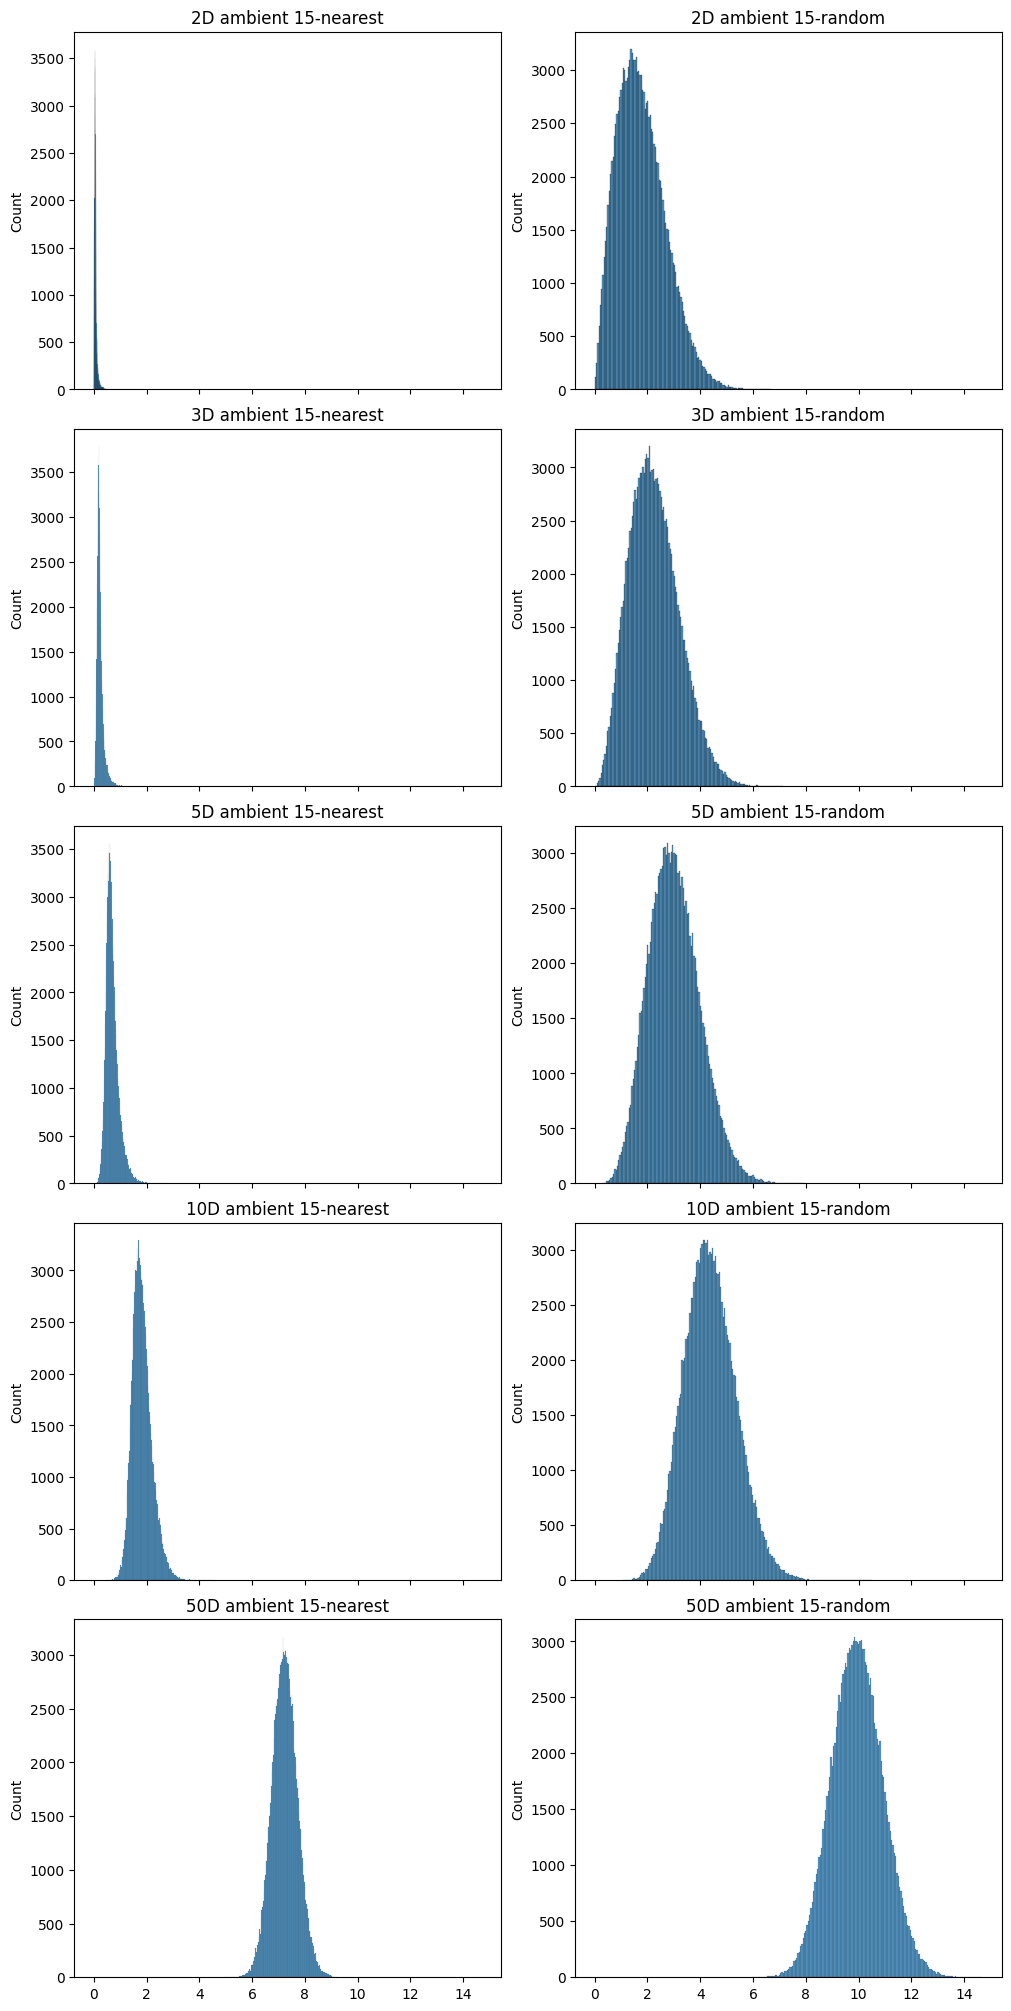

time: 6.43 s (started: 2023-01-31 21:46:46 -08:00)


In [5]:
show_all(g2dnbrs, g3dnbrs, g5dnbrs, g10dnbrs, g50dnbrs, method="ambient", sharex=True)

The distance concentration is apparent here, with the nearest neighbor distribution getting more and more similar to the random neighbor distribution as dimensionality increases. Also, both distributions of distances:

* shift away from zero
* become more symmetric

It's a little hard to see what is happening with the low-dimensional nearest neighbor distances, so here are the 2D, 3D, and 5D results again, but without sharing the x-axis:

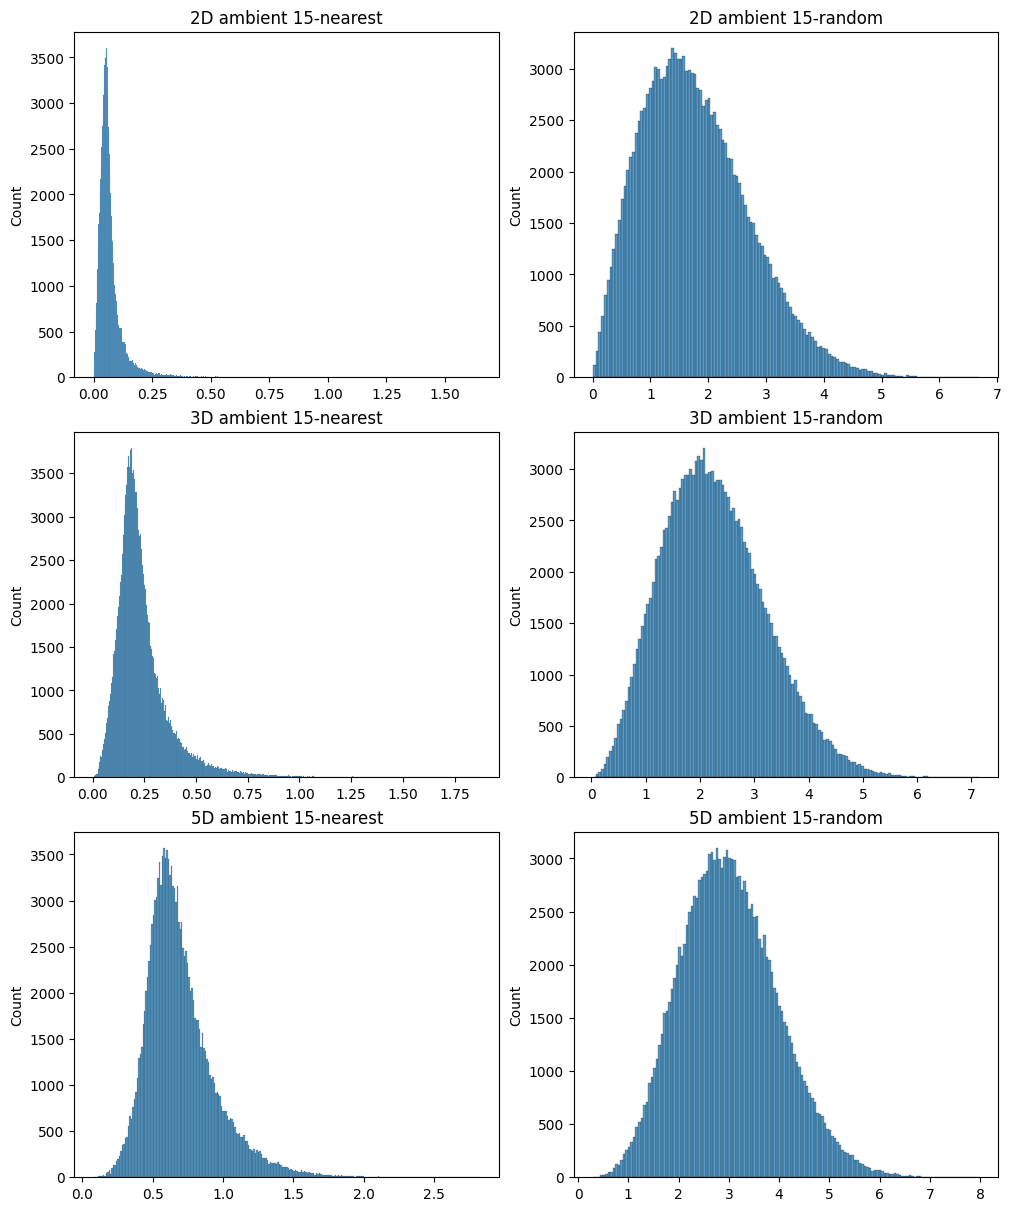

time: 4.2 s (started: 2023-01-31 21:46:53 -08:00)


In [6]:
show_all(g2dnbrs, g3dnbrs, g5dnbrs, method="ambient")

There is a skew of the neighbors at low dimensions which is particularly noticeable for the nearest neighbors.

All of that demonstrates that high-dimensional distances do not bear much resemblance to low-dimensional ones. That does not bode well for trying to preserve high-dimensional distances in a lower dimensions.

### PCA on Gaussians

Now let's look at what using PCA to reduce to 2D does to these distance distributions.

In [7]:
g2dnbrs.embed("pca")
g3dnbrs.embed("pca")
g5dnbrs.embed("pca")
g10dnbrs.embed("pca")
g50dnbrs.embed("pca")

[21:46:57] INFO     Running PCA                                                                           ]8;id=298081;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=545694;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

           INFO     Embedding completed                                                                   ]8;id=467425;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=786504;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

[21:46:58] INFO     Running PCA                                                                           ]8;id=834927;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=519157;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

           INFO     Embedding completed                                                                   ]8;id=519951;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=576963;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

           INFO     Running PCA                                                                           ]8;id=218137;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=519393;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

[21:46:59] INFO     Embedding completed                                                                   ]8;id=892545;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=146579;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

           INFO     Running PCA                                                                           ]8;id=19771;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=868658;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

           INFO     Embedding completed                                                                   ]8;id=931132;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=212524;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

           INFO     Running PCA                                                                           ]8;id=199985;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=764979;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

           INFO     Embedding completed                                                                   ]8;id=53951;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=140865;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

time: 2.02 s (started: 2023-01-31 21:46:57 -08:00)


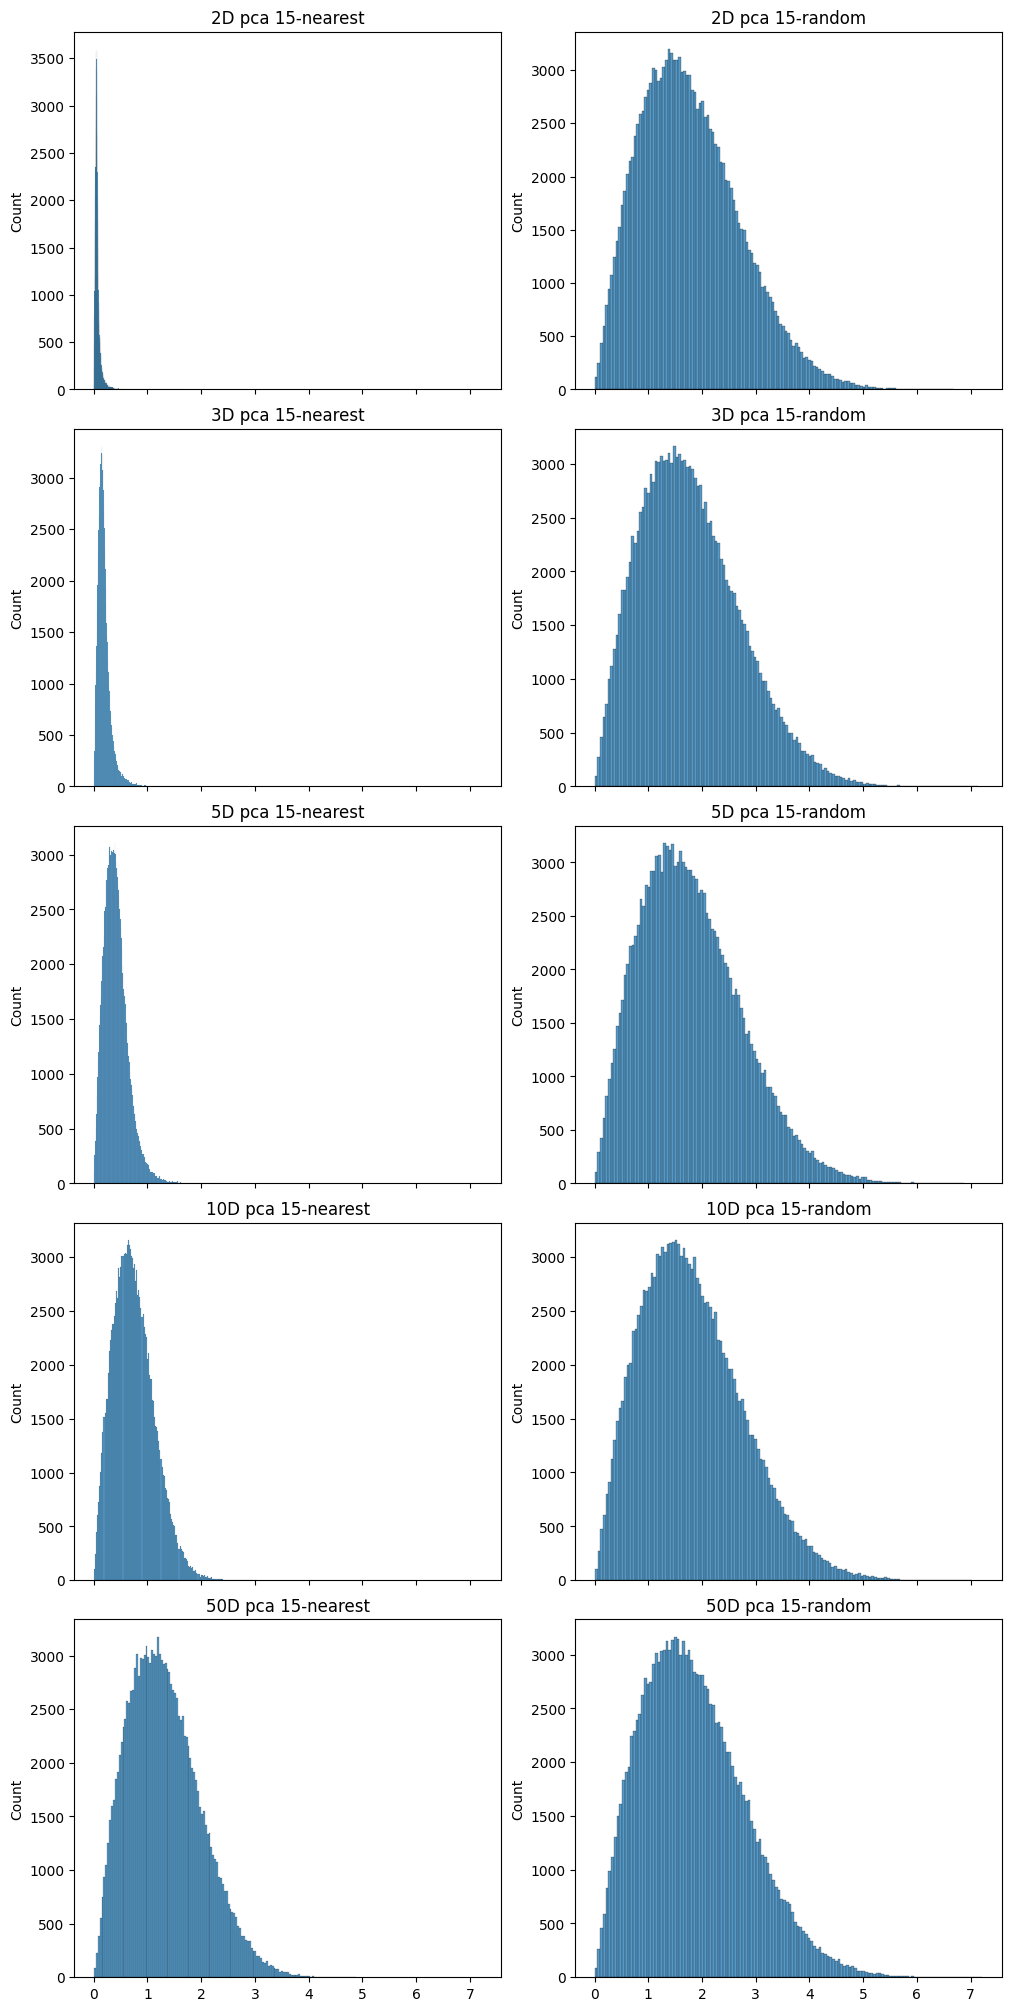

time: 6.17 s (started: 2023-01-31 21:46:59 -08:00)


In [8]:
show_all(g2dnbrs, g3dnbrs, g5dnbrs, g10dnbrs, g50dnbrs, method="pca", sharex=True)

We would expect extracting 2 components from a 2D Gaussian would give the same results as with the raw ambient distances, and that is the case, so the first row is of interest only as a reference to what the ambient 2D distances look like.

There is an obvious difference in the trend as the dimensionality of the Gaussians increases: the distance does not shift rightwards to a great degree and the skewness of the distribution remains. In fact, for the random neighbors, the distribution is basically unchanged. This isn't too surprising as the embedding space is a 2D distribution, so we get a 2D-like distribution regardless of what the original ambient dimensionality.

For nearest neighbors, we *do* see a shift of the distribution becoming closer to the random neighbor distribution. So this should makes it pretty clear that PCA on high-dimensional data is not going to preserve much local structure.

One other quirk of PCA is apparent if you plot the distances of PCA against the ambient distances. Here's the 3D results:

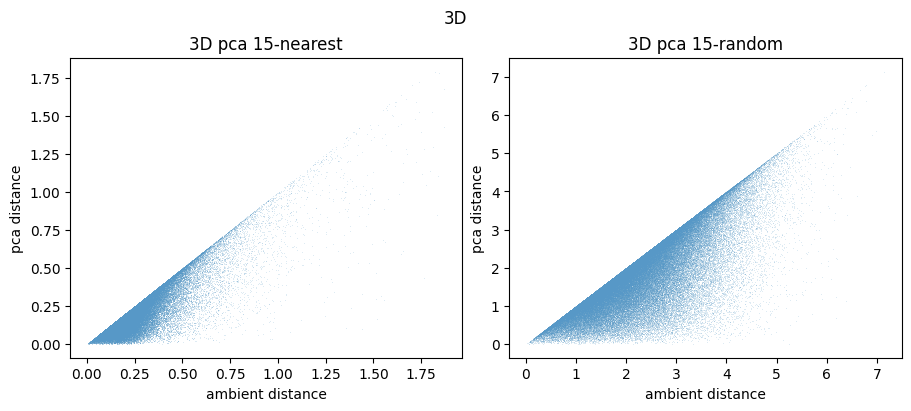

time: 810 ms (started: 2023-01-31 21:47:05 -08:00)


In [9]:
g3dnbrs.dscatter("pca")

The shape of these plots -- where there are no points found in the upper left quadrant -- means that when PCA transforms points, it will always *reduce* the distance between points if it has to. It *never* increases the distance. This is not surprising when you think about how the amount of variance "explained" of the original dataset approaches 100% from below as components are extracted. Here's the 10D example to confirm the behavior:

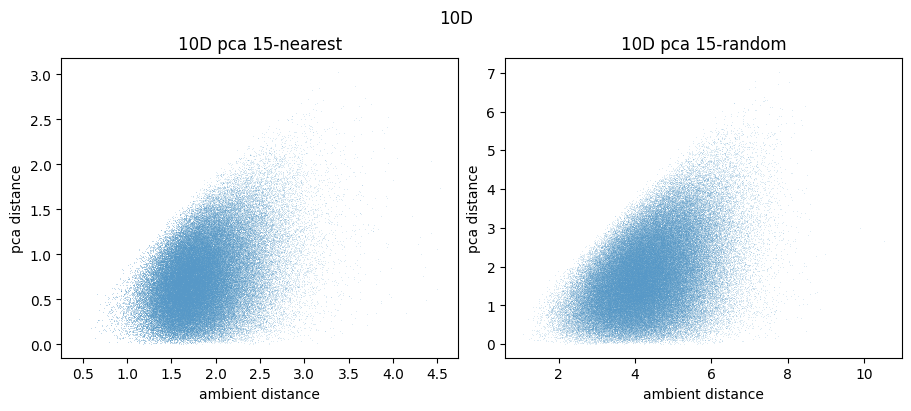

time: 572 ms (started: 2023-01-31 21:47:06 -08:00)


In [10]:
g10dnbrs.dscatter("pca")

### Stochastic Metric MDS

To determine how much of the above is a quirk specific to PCA, here are some results using a stochastic version of MMDS, initialized from PCA. While not shown here, I have determined that these settings *do* reduce the stress of the result compared to PCA, i.e. the distances are better reproduced after applying SMMDS. Note also that a sufficiently long optimization with full MMDS starting from a random initialization will give a better-than-PCA stress with qualitatively similar results, i.e. the results are *not* a quirk of the stochastic nature of the algorithm or due to a bias from starting from the PCA result.

In [11]:
smmds_params = dict(learning_rate=0.001, n_epochs=5000, random_state=42)
g2dnbrs.embed("smmds", params=smmds_params)
g3dnbrs.embed("smmds", params=smmds_params)
g5dnbrs.embed("smmds", params=smmds_params)
g10dnbrs.embed("smmds", params=smmds_params)
# For the 50D result, I needed to use a larger learning rate to get decent convergence in 5000 epochs
g50dnbrs.embed("smmds", params=dict(learning_rate=0.01, n_epochs=5000, random_state=42))

[21:47:06] INFO     Running SMMDS                                                                      ]8;id=557657;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=731122;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

[21:47:07] INFO     Initializing via (unscaled) PCA                                                     ]8;id=413342;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=455848;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[21:47:28] INFO     Embedding completed                                                                ]8;id=620137;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=372814;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

[21:47:29] INFO     Running SMMDS                                                                      ]8;id=891295;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=203788;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

           INFO     Initializing via (unscaled) PCA                                                     ]8;id=270727;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=289257;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[21:47:47] INFO     Embedding completed                                                                ]8;id=235719;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=350644;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

           INFO     Running SMMDS                                                                      ]8;id=709809;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=511541;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

           INFO     Initializing via (unscaled) PCA                                                     ]8;id=169151;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=814824;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[21:48:04] INFO     Embedding completed                                                                ]8;id=849141;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=151393;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

           INFO     Running SMMDS                                                                      ]8;id=37310;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=239694;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

           INFO     Initializing via (unscaled) PCA                                                     ]8;id=99814;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=252328;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[21:48:22] INFO     Embedding completed                                                                ]8;id=451539;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=510036;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

           INFO     Running SMMDS                                                                      ]8;id=154773;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=984402;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

           INFO     Initializing via (unscaled) PCA                                                     ]8;id=246964;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=707298;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[21:48:40] INFO     Embedding completed                                                                ]8;id=95083;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=433604;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

time: 1min 33s (started: 2023-01-31 21:47:06 -08:00)


First, checking in on the distributions:

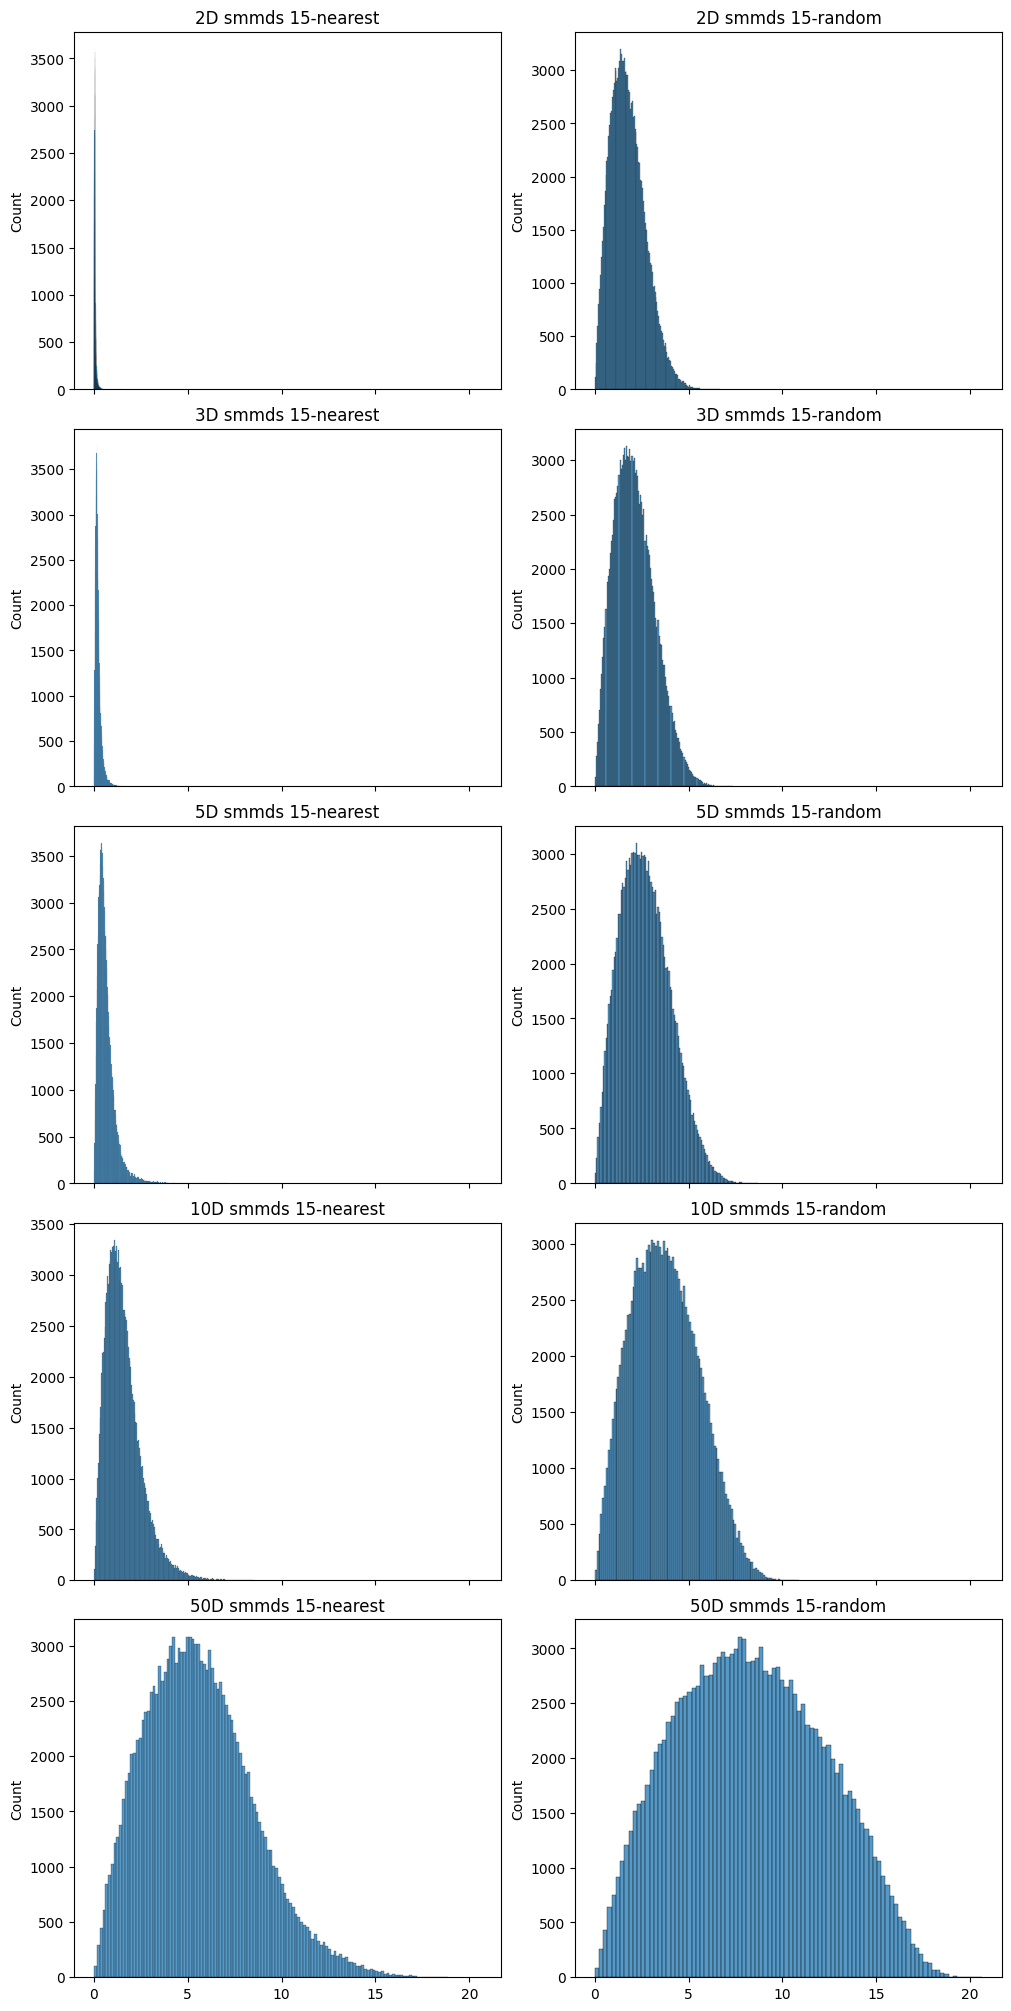

time: 6.99 s (started: 2023-01-31 21:48:40 -08:00)


In [12]:
show_all(g2dnbrs, g3dnbrs, g5dnbrs, g10dnbrs, g50dnbrs, method="smmds", sharex=True)

The 50D result is very different and is dominating the range of the shared x-axis now, so the `sharex=False` result is again useful: 

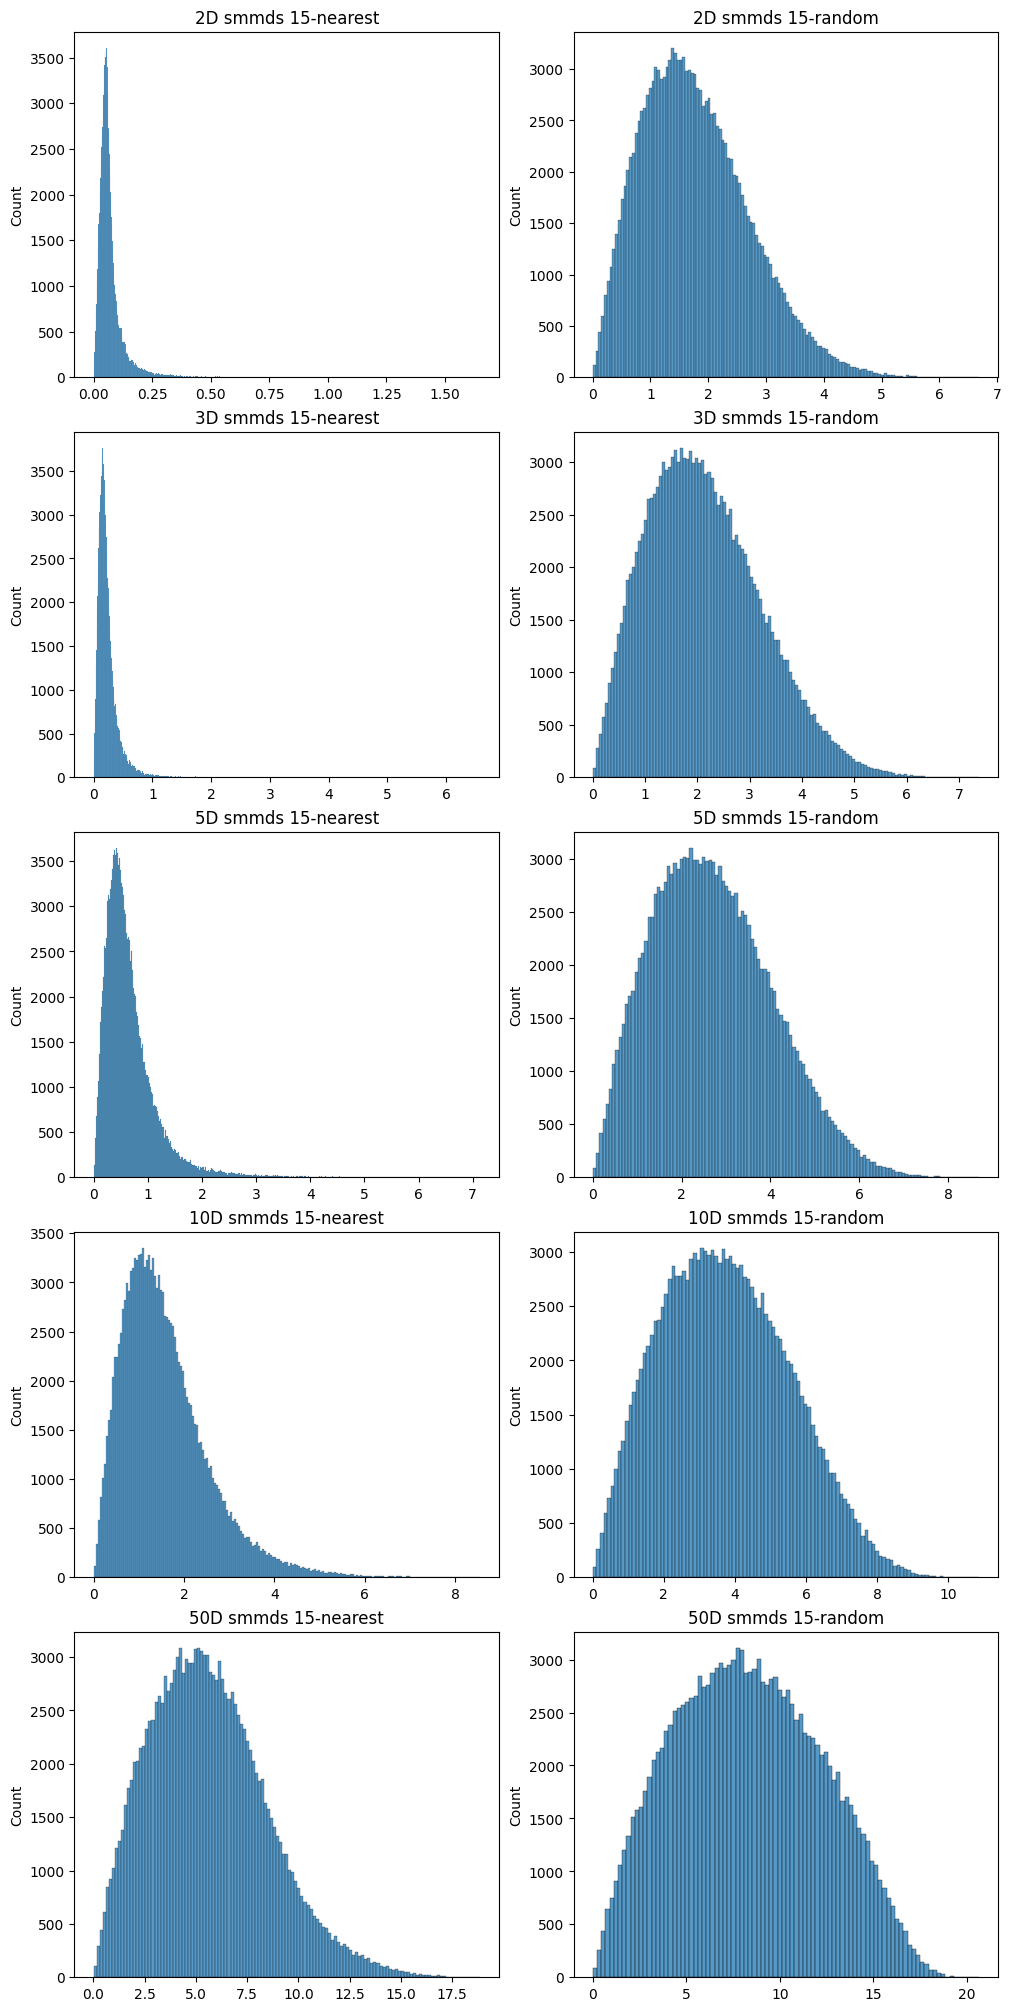

time: 6.98 s (started: 2023-01-31 21:48:47 -08:00)


In [13]:
show_all(g2dnbrs, g3dnbrs, g5dnbrs, g10dnbrs, g50dnbrs, method="smmds", sharex=False)

The pattern is still quite similar to the PCA results, but the extra optimization of distances seems to have increased and broadened the distributions. Here's the 50D distributions for the ambient, PCA and SMMDS distances:

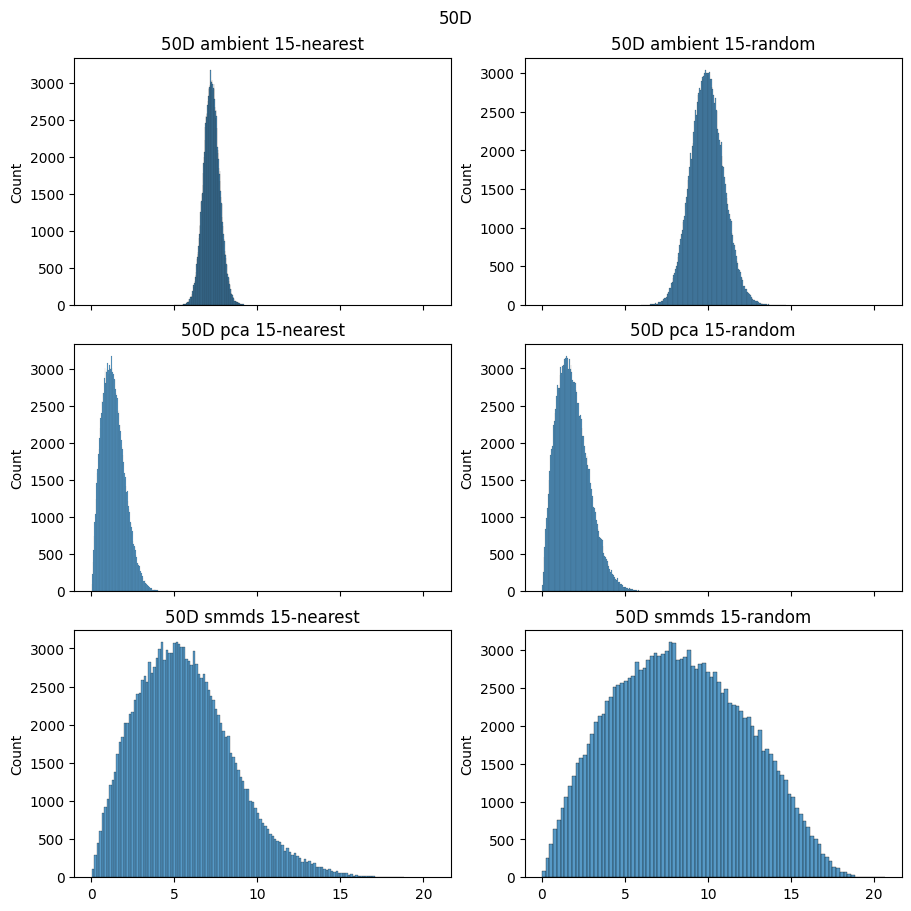

time: 2.44 s (started: 2023-01-31 21:48:54 -08:00)


In [14]:
g50dnbrs.dhist("ambient", "pca", "smmds", sharex=True)

So compared to PCA, SMMDS embedding into 2D is successful at shifting the distribution of distances so the median value gets closer to the high-dimensional values, but it can't match the spread of the distribution, nor the symmetry, with the nearest neighbor distribution having a noticeably broad right tail. A similar, but less pronounced pattern can be seen with the 5D Gaussian:

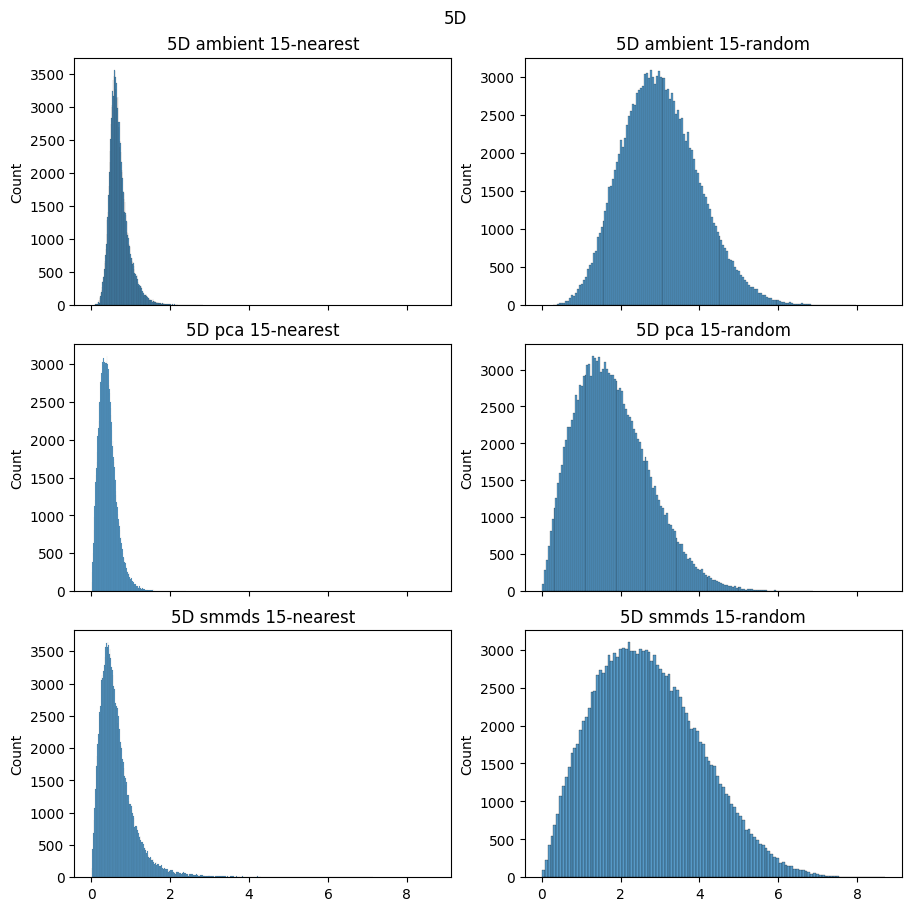

time: 3.19 s (started: 2023-01-31 21:48:57 -08:00)


In [15]:
g5dnbrs.dhist("ambient", "pca", "smmds", sharex=True)

We can also look at the scatterplot of how the distances are transformed which also clearly shows the shifting and broadening pattern:

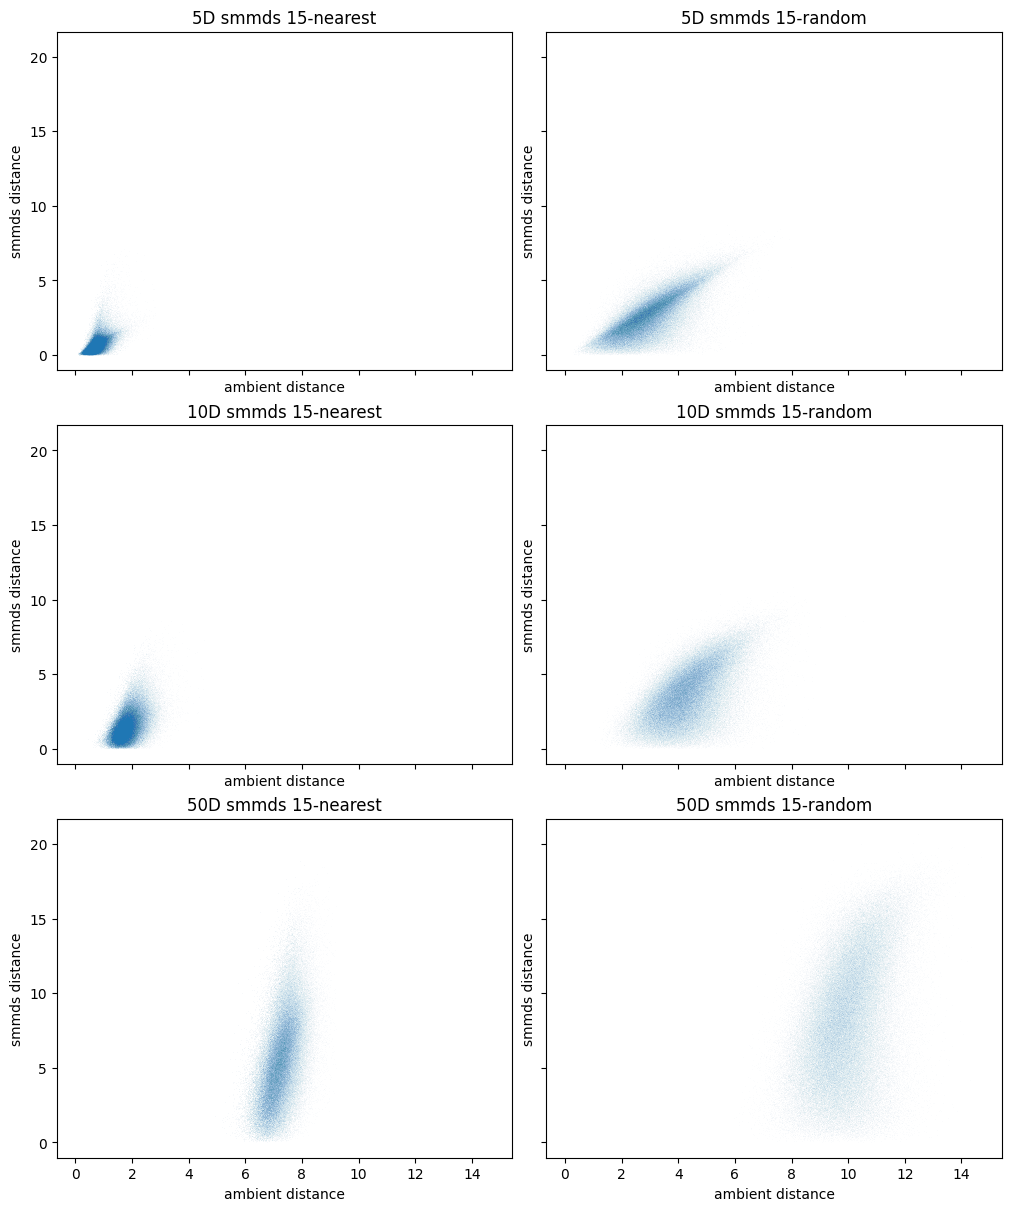

time: 1.47 s (started: 2023-01-31 21:49:00 -08:00)


In [16]:
show_scatter(
    g5dnbrs, g10dnbrs, g50dnbrs, name="smmds", alpha=0.1, sharex=True, sharey=True
)

Unlike PCA, SMDS is able to improve the reproduction of distances as a whole by allowing some distances to be larger in the embedded space than the ambient space. Here are the 50D PCA and SMMDS directly compared with a shared Y-axis that shows this clearly:

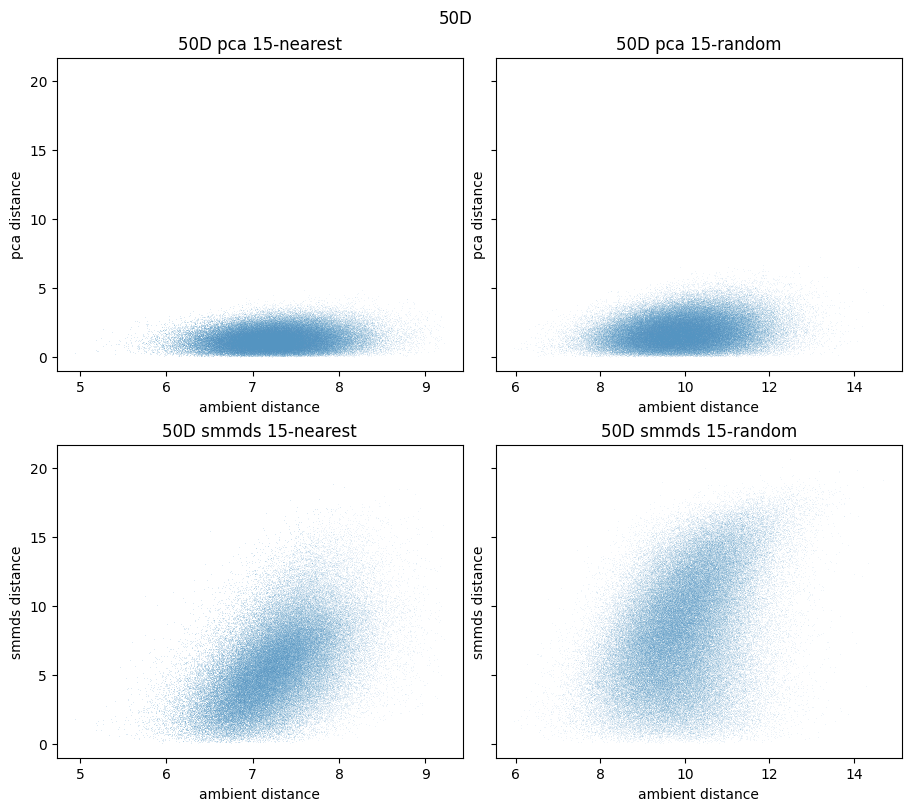

time: 881 ms (started: 2023-01-31 21:49:01 -08:00)


In [17]:
g50dnbrs.dscatter("pca", "smmds", sharey=True, alpha=0.5)

And here's a histogram of the *difference* between the smmds-embedded distances and the equivalent ambient distances for the random neighbors which demonstrates that there is still a tendency for the distances to be under-predicted, even though some distances are larger than in the ambient space:

<AxesSubplot: ylabel='Count'>

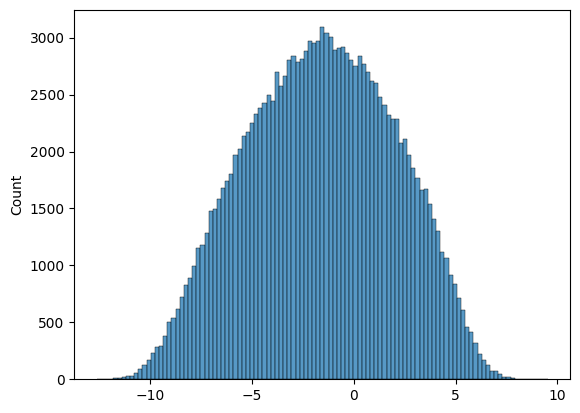

time: 324 ms (started: 2023-01-31 21:49:02 -08:00)


In [18]:
ann, arn = g50dnbrs.distances("ambient")
snn, srn = g50dnbrs.distances("smmds")
sns.histplot(srn - arn)

The bulk of the disparity in distances are below 0.

## UMAP on Gaussians

Ok, so we have a pretty good idea of what methods that attempt to preserve distance do. How does UMAP compare? To avoid complete graph overload, let's just look at the 10D and 50D case for now.

In [19]:
g10dnbrs.embed("umap")
g50dnbrs.embed("umap")

[21:49:03] INFO     Running UMAP                                                                        ]8;id=459216;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=821030;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#162\162]8;;\

[21:49:22] INFO     Embedding completed                                                                 ]8;id=845390;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=20917;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#167\167]8;;\

           INFO     Running UMAP                                                                        ]8;id=699587;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=163284;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#162\162]8;;\

[21:49:29] INFO     Embedding completed                                                                 ]8;id=693959;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=477927;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#167\167]8;;\

time: 26.7 s (started: 2023-01-31 21:49:03 -08:00)


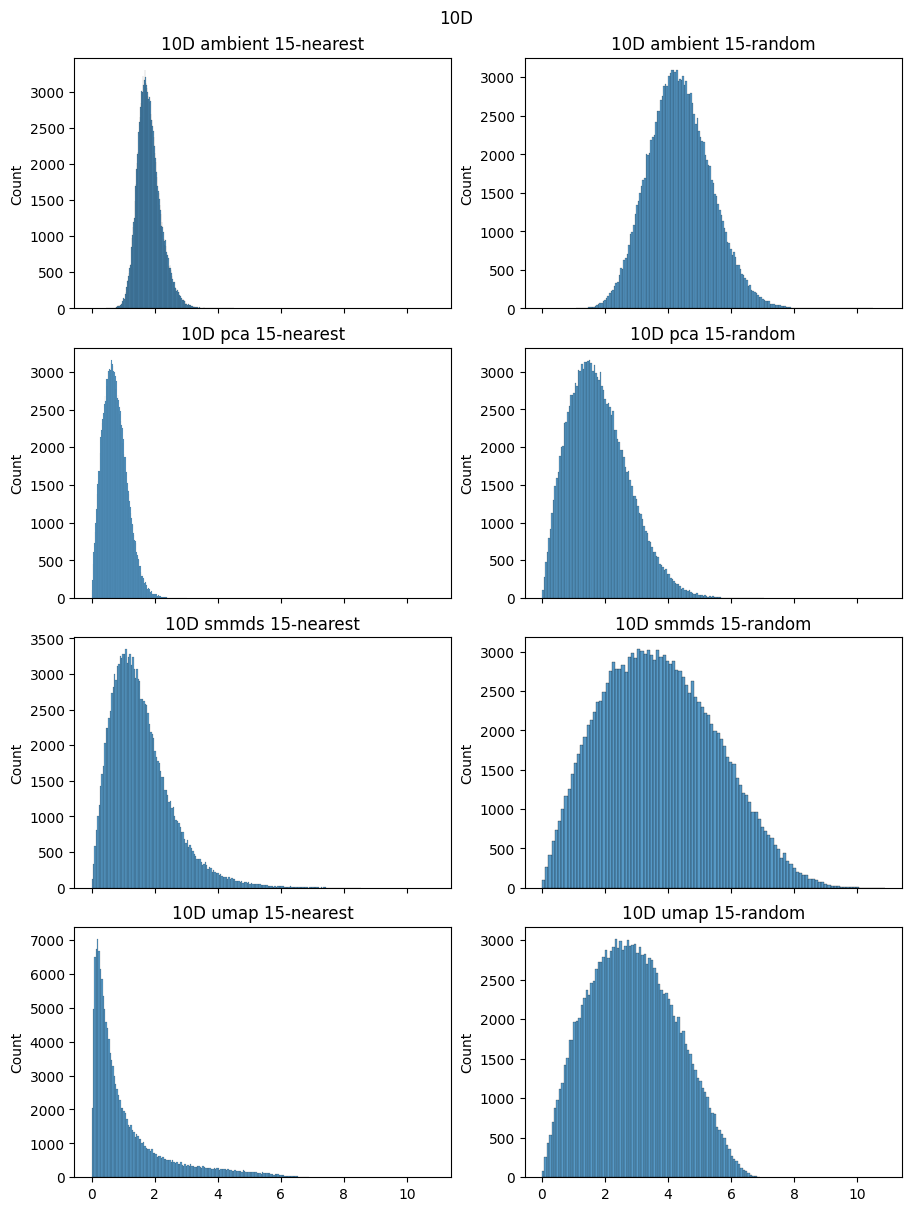

time: 3.52 s (started: 2023-01-31 21:49:29 -08:00)


In [20]:
g10dnbrs.dhist("ambient", "pca", "smmds", "umap", sharex=True)

Obviously there should be little expectation that UMAP preserves distances. The most obvious difference is how the nearest neighbor distribution looks: a sharp peak early, and then a long tail. Meanwhile the random neighbors are less broadly distributed and shifted to a lower distance compared to SMMDS.

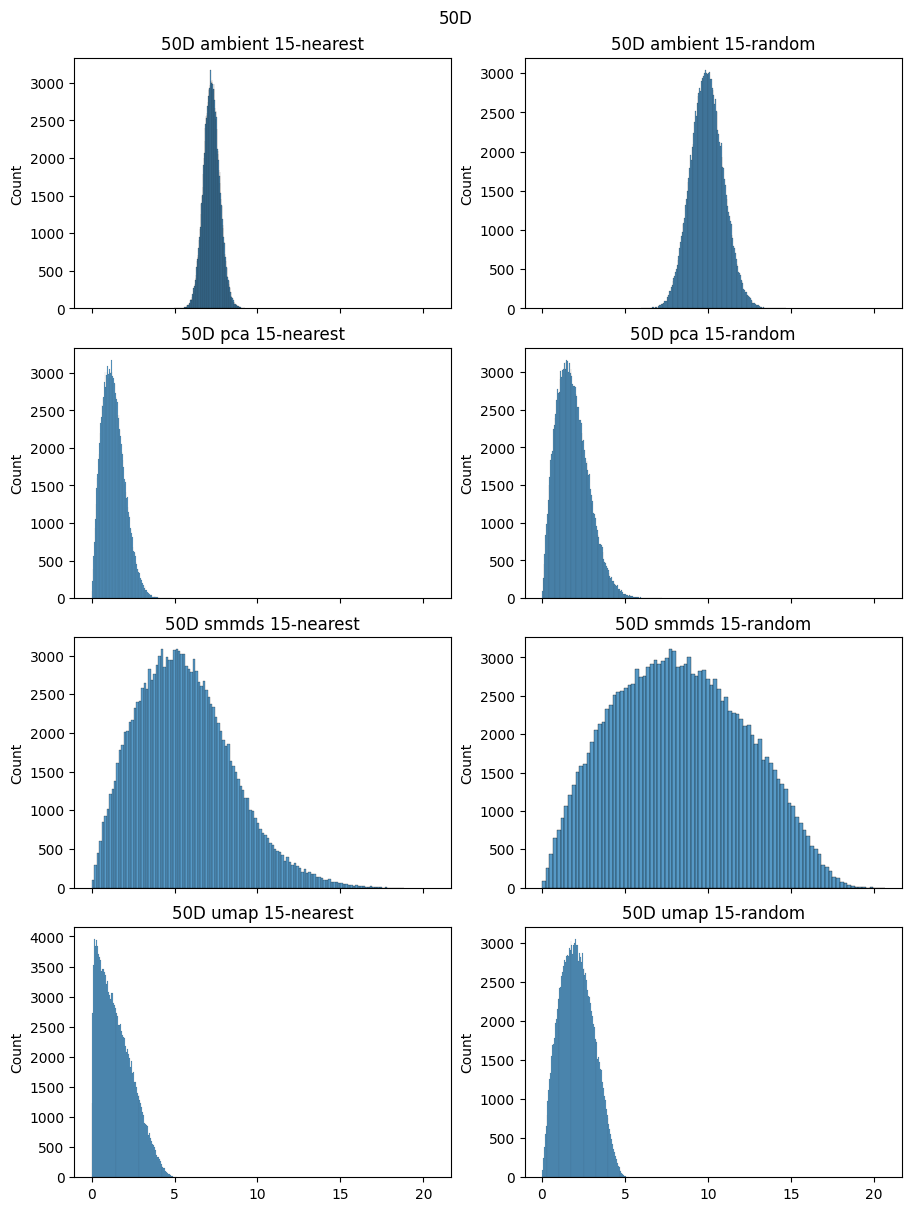

time: 3.42 s (started: 2023-01-31 21:49:33 -08:00)


In [21]:
g50dnbrs.dhist("ambient", "pca", "smmds", "umap", sharex=True)

In the 50D case, the nearest neighbors are even more interestingly distributed. The random neighbors have a distribution that seems to have a similar span to the nearest neighbors, but an obviously high peak. Here's a closer look at just the PCA and UMAP results, as they are the most similar to each other:

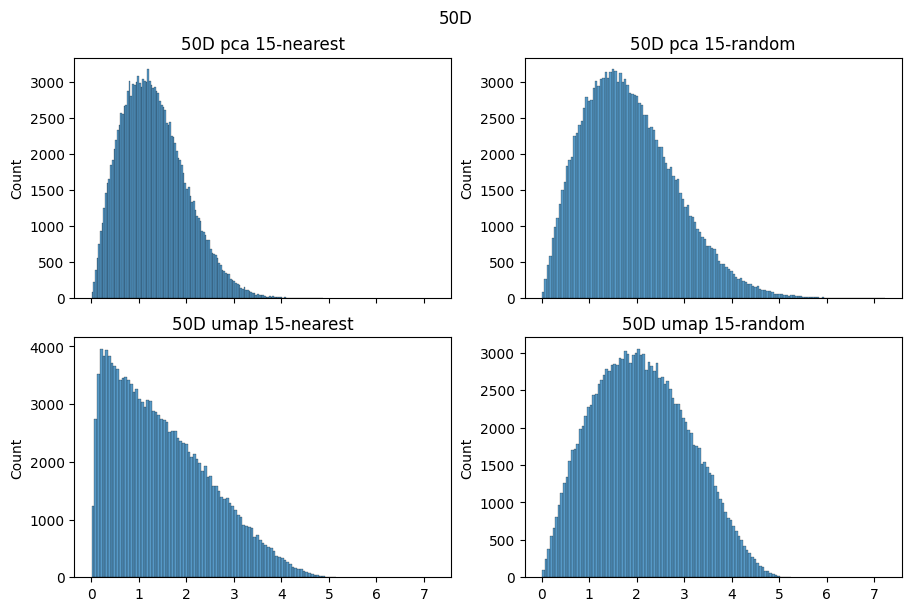

time: 1.58 s (started: 2023-01-31 21:49:36 -08:00)


In [22]:
g50dnbrs.dhist("pca", "umap", sharex=True)

The distribution of the random neighbors really doesn't seem *that* different.

### t-SNE

Let's also take a look at t-SNE, again for the 10D and 50D case.

In [23]:
g10dnbrs.embed("tsne")
g50dnbrs.embed("tsne")

[21:49:38] INFO     Running t-SNE                                                                       ]8;id=231165;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=170013;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#110\110]8;;\

[21:49:43] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=272569;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=745451;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1329\1329]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=946524;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=752961;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[21:49:48] INFO     Automatically determined negative gradient method `fft`                              ]8;id=858104;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=183670;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[21:50:03] INFO     Embedding completed                                                                 ]8;id=36391;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=785741;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#113\113]8;;\

           INFO     Running t-SNE                                                                       ]8;id=145264;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=684140;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#110\110]8;;\

[21:50:08] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=918279;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=502482;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1329\1329]8;;\

[21:50:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=27214;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=922466;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[21:50:14] INFO     Automatically determined negative gradient method `fft`                              ]8;id=214179;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=996476;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[21:50:24] INFO     Embedding completed                                                                 ]8;id=576795;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=408079;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#113\113]8;;\

time: 46.5 s (started: 2023-01-31 21:49:38 -08:00)


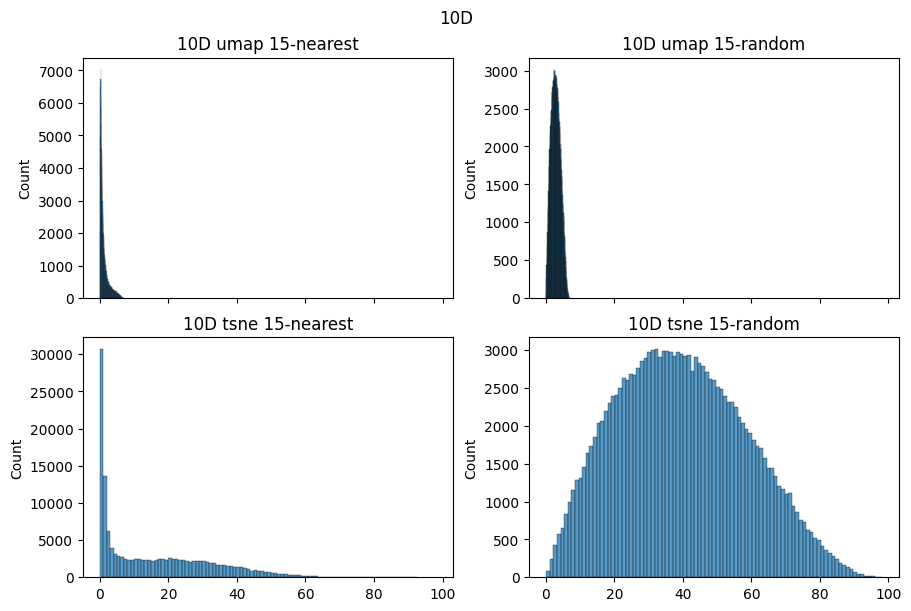

time: 1.75 s (started: 2023-01-31 21:50:24 -08:00)


In [24]:
g10dnbrs.dhist("umap", "tsne", sharex=True)

The t-SNE distances are on a completely different scale to UMAP's (and any of the other methods we have looked at). The nearest neighbor distribution resembles UMAP's to the extent of a concentration of very short distances and then a long (slightly bimodal?) tail. Meanwhile, the random distances show a much broader more symmetric pattern.

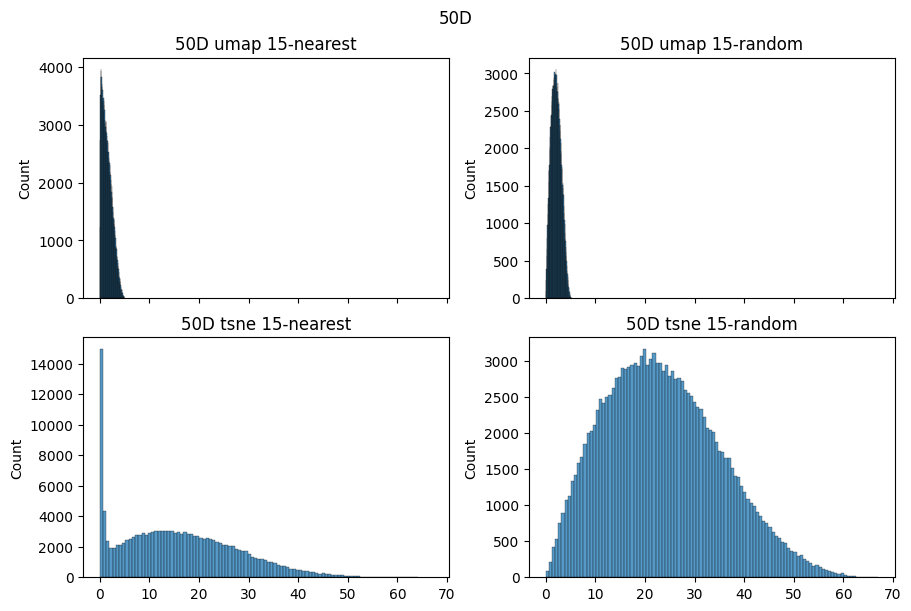

time: 1.49 s (started: 2023-01-31 21:50:26 -08:00)


In [25]:
g50dnbrs.dhist("umap", "tsne", sharex=True)

A similar pattern here, with the bimodal distribution for nearest neighbors more obvious. For the random neighbors, an asymmetry in the distribution is also apparent.

Now let's look at the scatter plots:

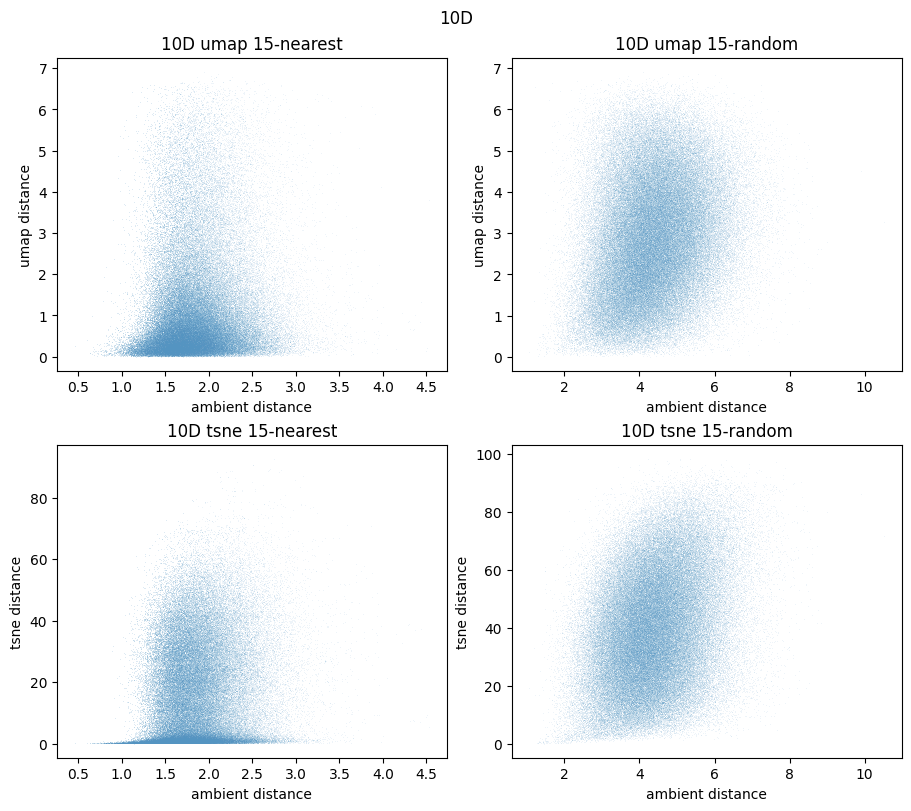

time: 1.06 s (started: 2023-01-31 21:50:28 -08:00)


In [26]:
g10dnbrs.dscatter("umap", "tsne", alpha=0.5)

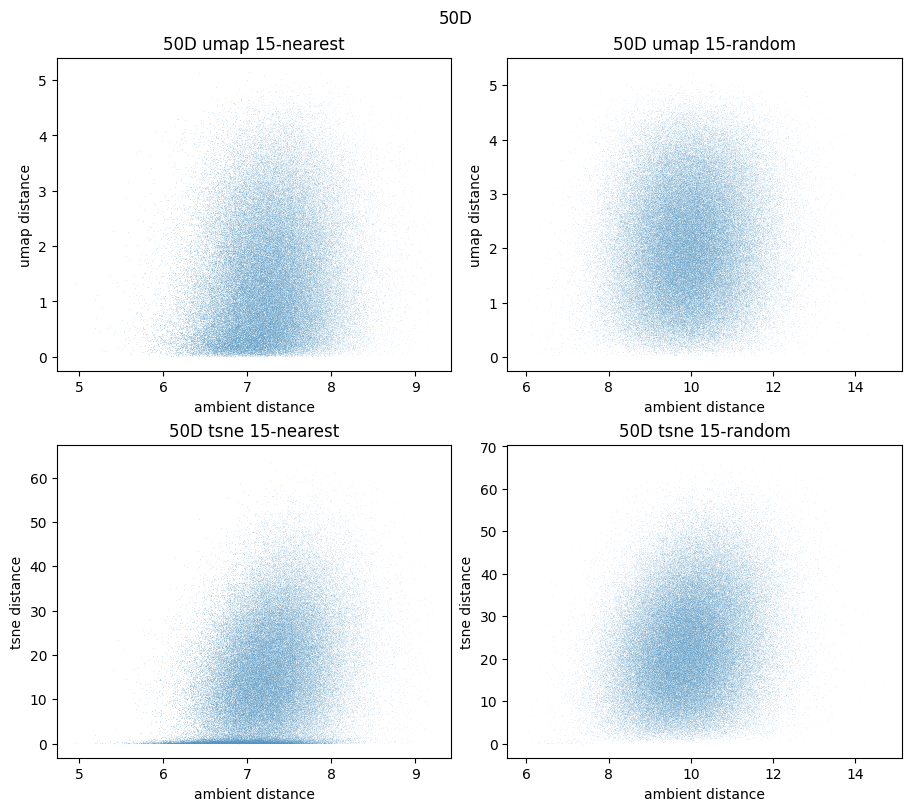

time: 1.03 s (started: 2023-01-31 21:50:29 -08:00)


In [27]:
g50dnbrs.dscatter("umap", "tsne", alpha=0.5)

These are very different from the PCA and SMMDS results. Really very hard to detect any sort of relationship between the ambient and embedded distances (which again should not be too surprising).

## MNIST

In [28]:
from drnb.io.dataset import read_data

mnist = read_data("mnist")
mnistnbrs = DataNeighbors(mnist, data_name="mnist")

time: 11.8 s (started: 2023-01-31 21:50:30 -08:00)


In [29]:
mnistnbrs.embed("pca")
mnistnbrs.embed(
    "smmds", params=dict(learning_rate=1.0, n_epochs=10000, random_state=42)
)

[21:50:42] INFO     Running PCA                                                                           ]8;id=262639;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=310945;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

[21:50:44] INFO     Embedding completed                                                                   ]8;id=465985;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=272171;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

[21:50:45] INFO     Running SMMDS                                                                      ]8;id=78548;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=757851;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

           INFO     Initializing via (unscaled) PCA                                                     ]8;id=241445;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=498446;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[21:55:06] INFO     Embedding completed                                                                ]8;id=375001;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=663742;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

time: 4min 24s (started: 2023-01-31 21:50:42 -08:00)


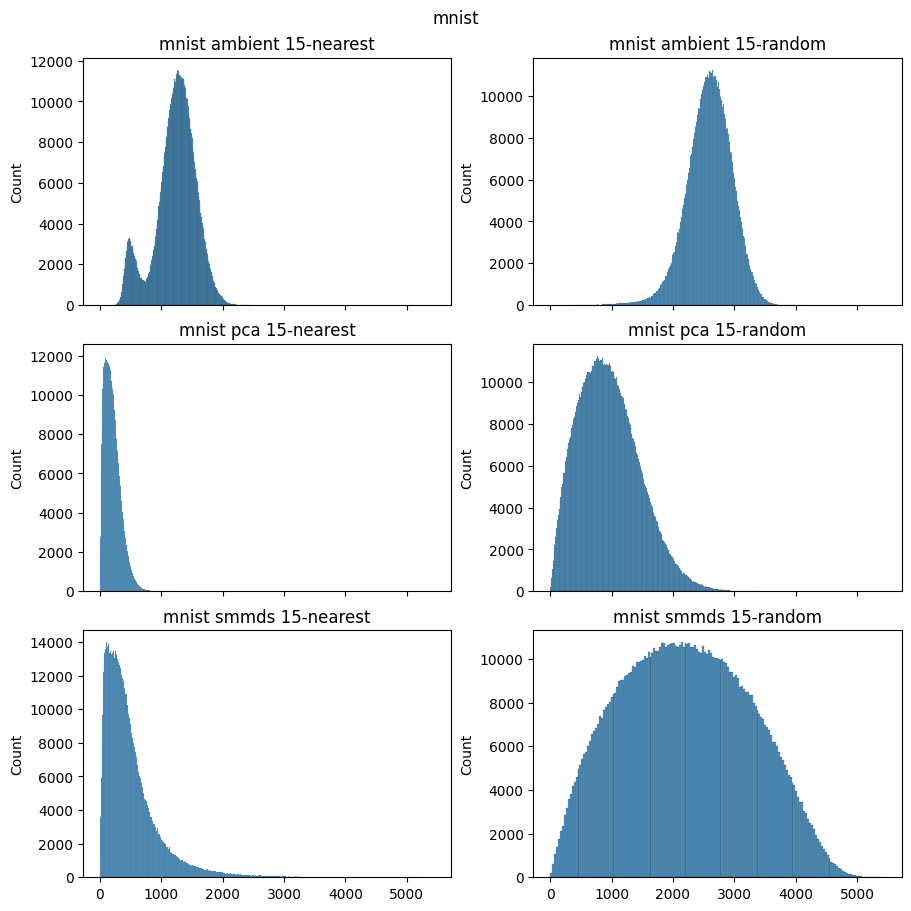

time: 6.12 s (started: 2023-01-31 21:55:06 -08:00)


In [30]:
mnistnbrs.dhist("ambient", "pca", "smmds", sharex=True)

In [31]:
mnistnbrs.embed("umap")
mnistnbrs.embed("tsne")

[21:55:13] INFO     Running UMAP                                                                        ]8;id=880913;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=134491;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#162\162]8;;\

[21:55:41] INFO     Embedding completed                                                                 ]8;id=965412;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=950178;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#167\167]8;;\

           INFO     Running t-SNE                                                                       ]8;id=951572;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=326463;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#110\110]8;;\

[21:59:11] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=105323;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=254165;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1329\1329]8;;\

[21:59:13] INFO     Automatically determined negative gradient method `fft`                              ]8;id=296644;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=510027;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[21:59:35] INFO     Automatically determined negative gradient method `fft`                              ]8;id=703611;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=315639;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[22:00:44] INFO     Embedding completed                                                                 ]8;id=616423;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=229738;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#113\113]8;;\

time: 5min 31s (started: 2023-01-31 21:55:13 -08:00)


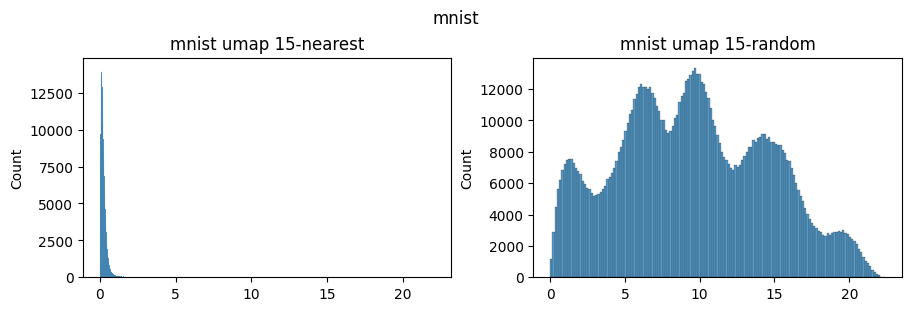

time: 7.74 s (started: 2023-01-31 22:00:44 -08:00)


In [32]:
mnistnbrs.dhist("umap")

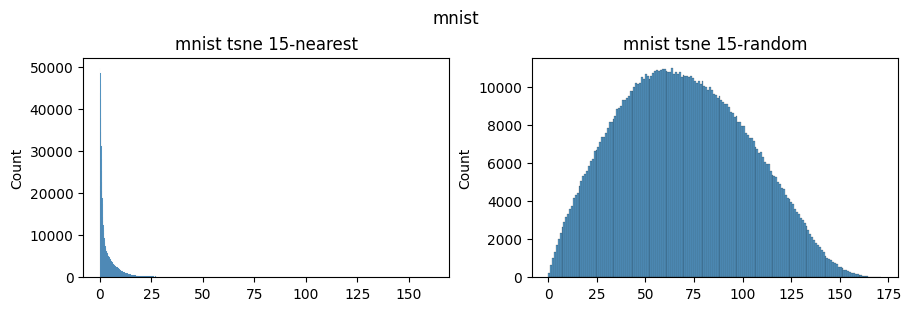

time: 3.32 s (started: 2023-01-31 22:00:52 -08:00)


In [33]:
mnistnbrs.dhist("tsne")

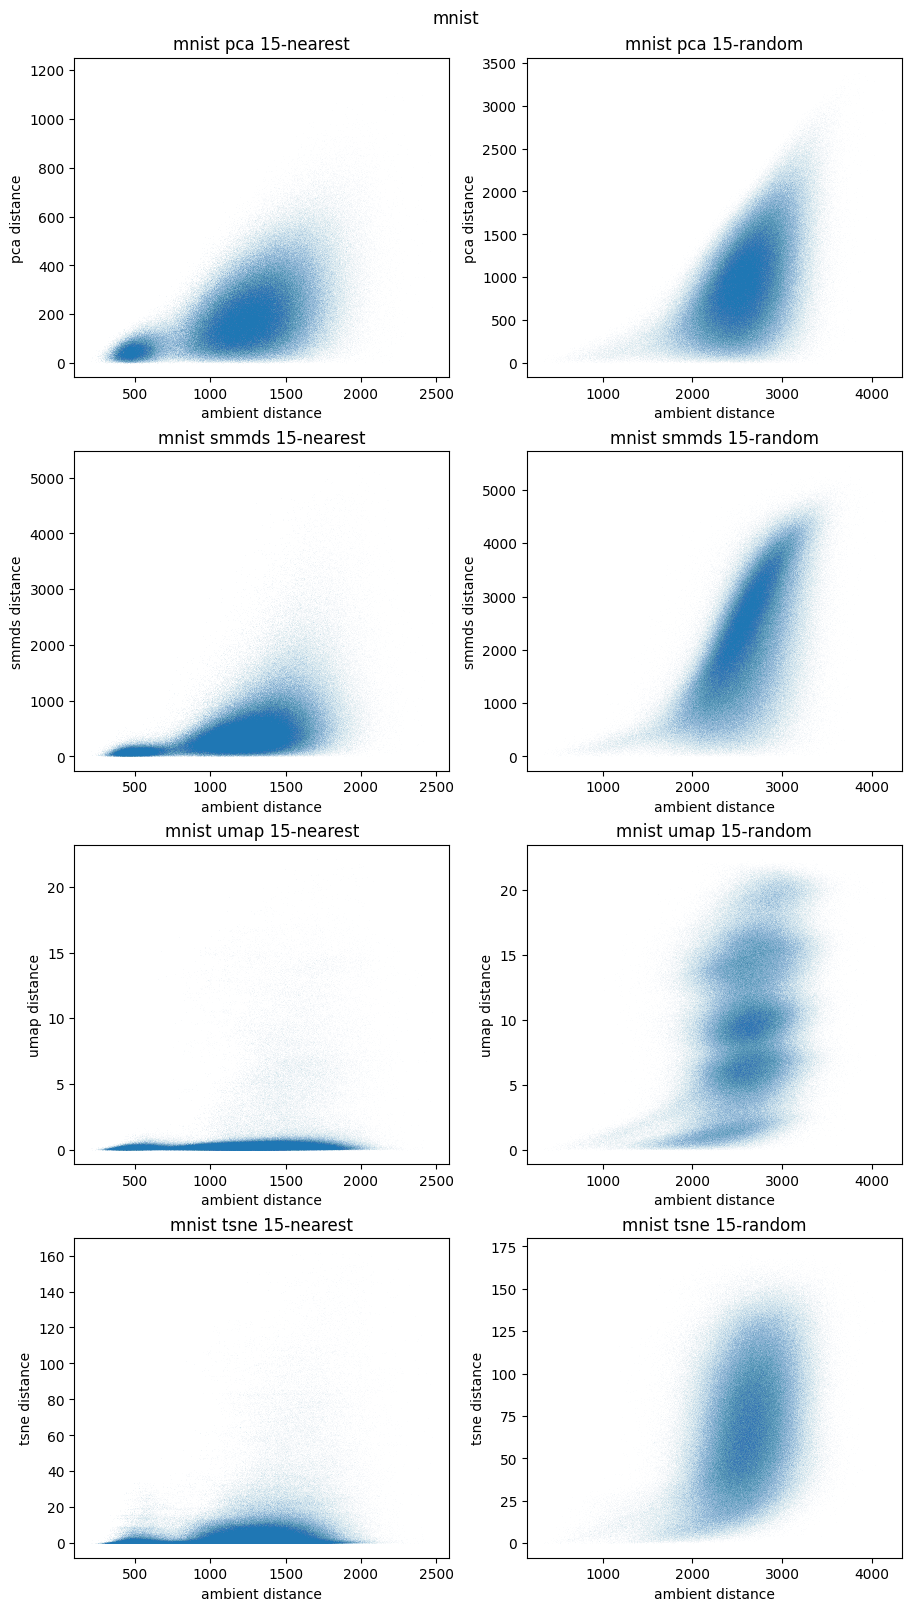

time: 5.2 s (started: 2023-01-31 22:00:55 -08:00)


In [34]:
mnistnbrs.dscatter("pca", "smmds", "umap", "tsne", alpha=0.1)

## FMNIST (Fashion)

In [35]:
fashion = read_data("fashion")
fashionnbrs = DataNeighbors(fashion, data_name="fashion")

time: 14.1 s (started: 2023-01-31 22:01:00 -08:00)


In [36]:
fashionnbrs.embed("pca")
fashionnbrs.embed(
    "smmds", params=dict(learning_rate=1.0, n_epochs=10000, random_state=42)
)

[22:01:14] INFO     Running PCA                                                                           ]8;id=860549;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=517940;file:///home/james/dev/drnb/src/drnb/embed/pca.py#20\20]8;;\

[22:01:17] INFO     Embedding completed                                                                   ]8;id=501523;file:///home/james/dev/drnb/src/drnb/embed/pca.py\pca.py]8;;\:]8;id=148581;file:///home/james/dev/drnb/src/drnb/embed/pca.py#23\23]8;;\

           INFO     Running SMMDS                                                                      ]8;id=51103;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=274611;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#117\117]8;;\

           INFO     Initializing via (unscaled) PCA                                                     ]8;id=914996;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=96757;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

[22:05:33] INFO     Embedding completed                                                                ]8;id=864440;file:///home/james/dev/drnb/src/drnb/embed/smmds.py\smmds.py]8;;\:]8;id=159309;file:///home/james/dev/drnb/src/drnb/embed/smmds.py#120\120]8;;\

time: 4min 19s (started: 2023-01-31 22:01:14 -08:00)


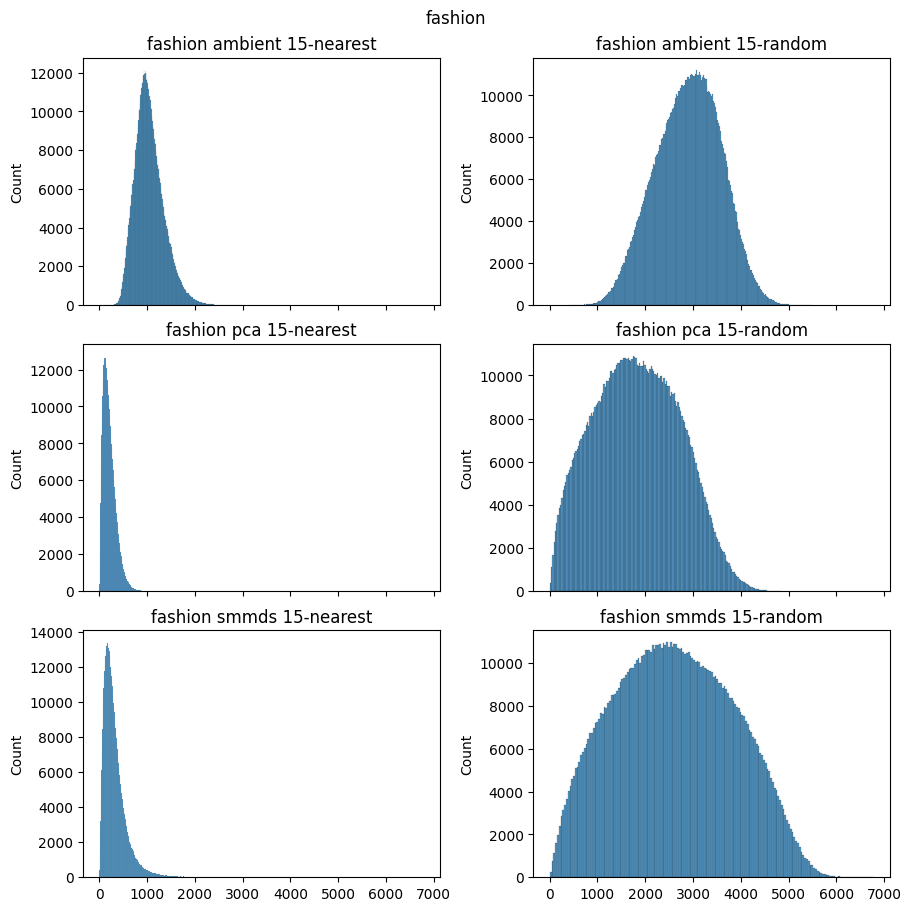

time: 6.66 s (started: 2023-01-31 22:05:34 -08:00)


In [37]:
fashionnbrs.dhist("ambient", "pca", "smmds", sharex=True)

In [38]:
fashionnbrs.embed("umap")
fashionnbrs.embed("tsne")

[22:05:40] INFO     Running UMAP                                                                        ]8;id=893168;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=186135;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#162\162]8;;\

[22:06:11] INFO     Embedding completed                                                                 ]8;id=307661;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=202450;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#167\167]8;;\

           INFO     Running t-SNE                                                                       ]8;id=969881;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=279623;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#110\110]8;;\

[22:09:08] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=408277;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=678936;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1329\1329]8;;\

[22:09:10] INFO     Automatically determined negative gradient method `fft`                              ]8;id=386765;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=62844;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[22:09:35] INFO     Automatically determined negative gradient method `fft`                              ]8;id=968919;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=934815;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[22:10:46] INFO     Embedding completed                                                                 ]8;id=417269;file:///home/james/dev/drnb/src/drnb/embed/tsne.py\tsne.py]8;;\:]8;id=564928;file:///home/james/dev/drnb/src/drnb/embed/tsne.py#113\113]8;;\

time: 5min 5s (started: 2023-01-31 22:05:40 -08:00)


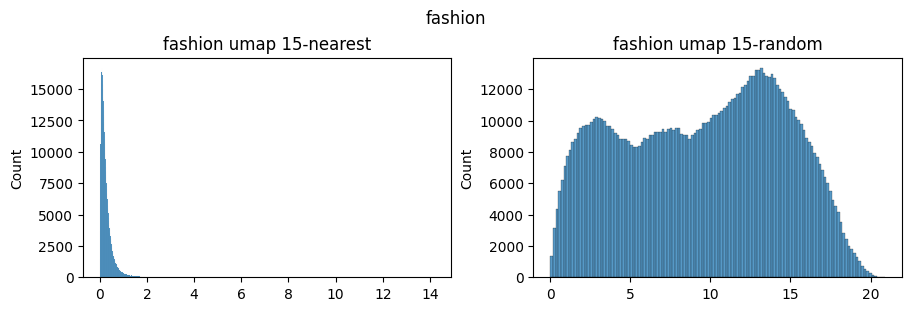

time: 5.16 s (started: 2023-01-31 22:10:46 -08:00)


In [39]:
fashionnbrs.dhist("umap")

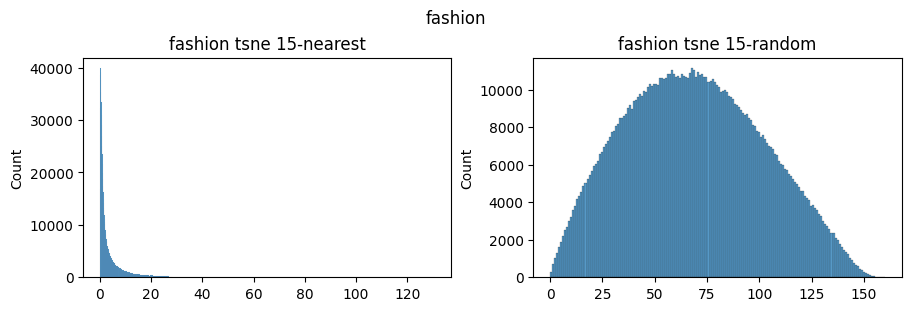

time: 3.48 s (started: 2023-01-31 22:10:51 -08:00)


In [40]:
fashionnbrs.dhist("tsne")

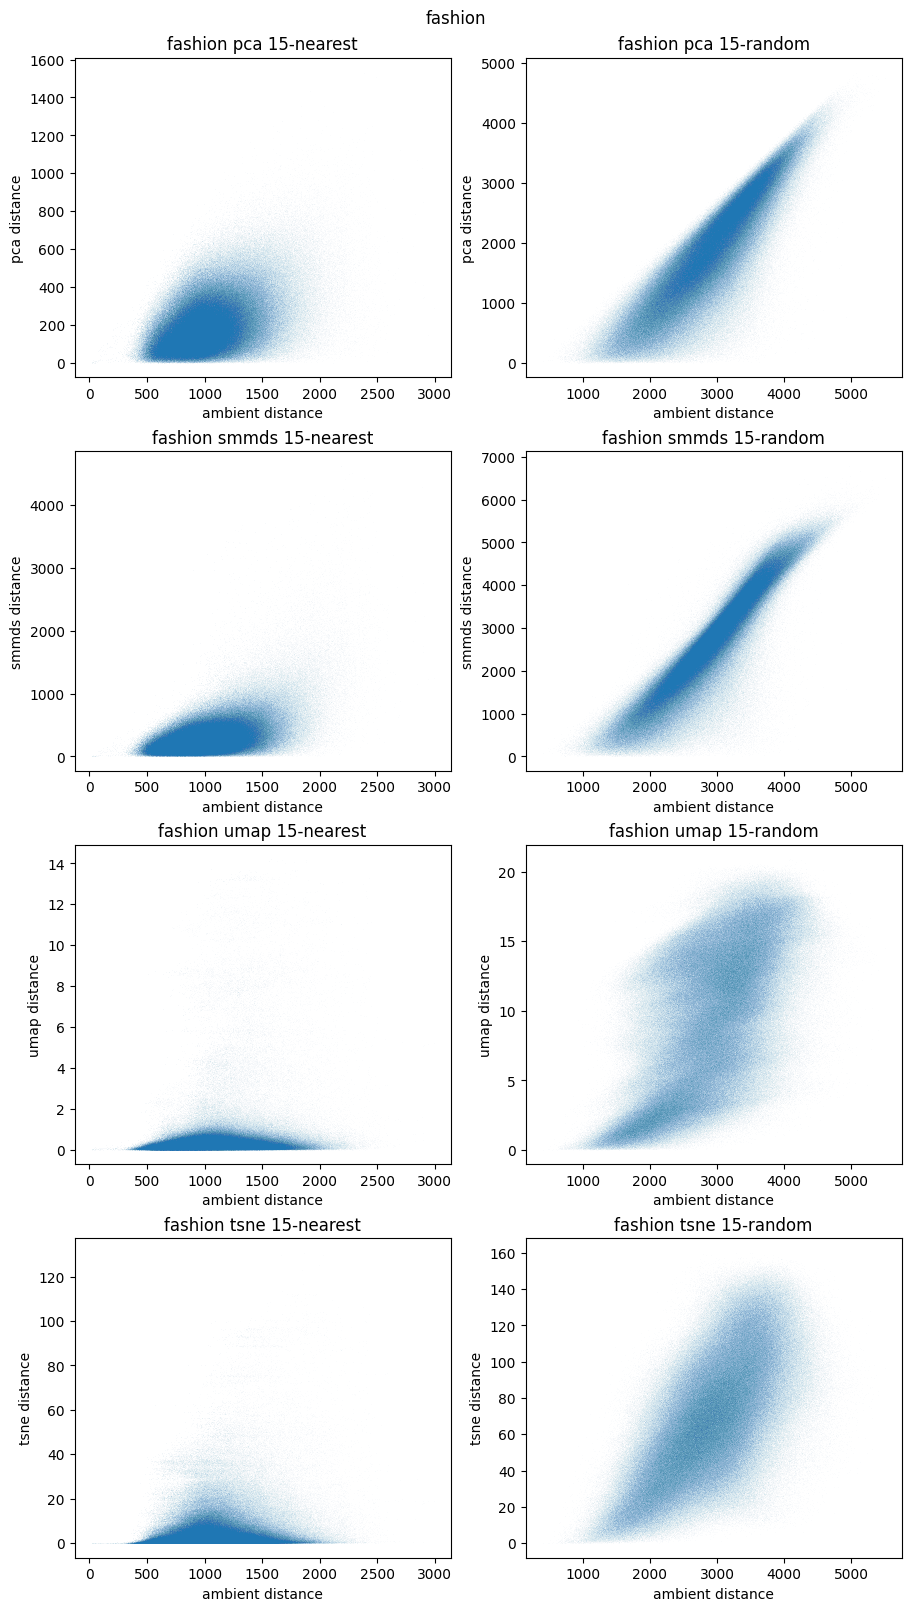

time: 5.17 s (started: 2023-01-31 22:10:55 -08:00)


In [41]:
fashionnbrs.dscatter("pca", "smmds", "umap", "tsne", alpha=0.1)